<a href="https://colab.research.google.com/github/srikarraju/ADL/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy.random import seed
seed(1)

In [ ]:
from keras.datasets.mnist import load_data

(trainX, trainY), (testX, testY) = load_data()

print('Train', trainX.shape, trainY.shape)
print('Test', testX.shape, testY.shape)

11493376/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
trainX_Gan ,testX_Gan, trainY_Gan, testY_Gan = train_test_split(trainX,trainY,train_size = 0.2,random_state = 10)
class_count = np.zeros(10,dtype=int)
for i in range(len(trainY_Gan)):
  class_count[trainY_Gan[i]] += 1
print(class_count)

[1207 1399 1149 1170 1194 1036 1171 1248 1214 1212]


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Flatten,Softmax,LeakyReLU,Dense
from keras.optimizers import Adam
def mnist_classifier(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(10,activation='softmax'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
import numpy as np
def make_samples_3D(trainX_Gan):
	X = np.expand_dims(trainX_Gan, axis=-1)
	X = X.astype('float32')
	X = X / 255.0
	return X

In [ ]:
trainX_Gan_new = make_samples_3D(trainX_Gan)
print(trainX_Gan_new.shape)
model = mnist_classifier()
print(model.summary())
model.fit(trainX_Gan_new,trainY_Gan,epochs =3)

testX_new = make_samples_3D(testX)
print(testX_new.shape)
print(model.evaluate(testX_new,testY))

(12000, 28, 28, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3

In [ ]:
## Building a GAN
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
from numpy.random import rand,randint, randn
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [ ]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
# model_discriminator = define_discriminator()
# train_discriminator(model_discriminator,trainX_Gan_new)

In [ ]:
from keras.layers import Reshape, Conv2DTranspose, Conv2D
from keras.utils.vis_utils import plot_model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
def generate_samples_from_generator(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [ ]:
label9_samples = []
for i in range(len(trainY_Gan)):
  if trainY_Gan[i]==9:
    label9_samples.append(trainX_Gan_new[i])
label9_samples = np.asarray(label9_samples)

In [ ]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_samples_from_generator(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)
gan_model.summary()
#plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)
train(g_model, d_model, gan_model, label9_samples, latent_dim)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________
>1, 1/4, d=0.687, g=0.733
>1, 2/4, d=0.675, g=0.746
>1, 3/4, d=0.669, g=0.765
>1, 4/4, d=0.656, g=0.787
>2, 1/4, d=0.645, g=0.805
>2, 2/4, d=0.640, g=0.828
>2, 3/4, d=0.632, g=0.844
>2, 4/4, d=0.620, g=0.853
>3, 1/4, d=0.615, g=0.860
>3, 2/4, d=0.614, g=0.854
>3, 3/4, d=0.614, g=0.838
>3, 4/4, d=0.621, g=0.815
>4, 1/4, d=0.624, g=0.784
>4, 2/4, d=0.626, g=0.758
>4, 3/4, d=0.629, g=0.739
>4, 4/4, d=0.621, g=0.725
>5, 1/4, d=0.618, g=0.717
>5, 2/4, d=0.614, g=0.712
>5, 3/4, d=0.605, g=0.707
>5, 4/4

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/ADL/ADL_2/models/generator_model_label9'
g_model.save(filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/ADL/ADL_2/models/generator_model_label9/assets


In [ ]:
from matplotlib import pyplot
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

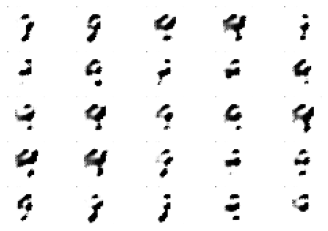

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab Notebooks/ADL/ADL_2/models/generator_model_label9')
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
save_plot(X, 5)